In [20]:
import random
import jiwer

import resource
import pickle
from resource import get_sentiment_lexicon

from textflint.common.settings import MODIFIED_MASK
from textflint.common.utils.word_op import swap
from textflint.generation.transformation import WordSubstitute
from textflint.generation.transformation.UT import Keyboard, Typos
from textflint.input.component.sample import UTSample
from utils import visualize_text_diff, Accent, TypoSwap, AddVowel
from torch.utils.data import DataLoader
import torch
import numpy as np
import pandas as pd
from allennlp.training.metrics import CategoricalAccuracy, Average

### Word Corruption Evaluation

In [40]:
def get_result(
    dataset_name, model_name,
    ):
    with open(f'outputs/{dataset_name}_noisy.pickle', 'rb') as file:
        noisy_data = pickle.load(file)
    with open(f'outputs_local/{dataset_name}_{model_name}.pickle', 'rb') as file:
        examples = pickle.load(file)
    df = pd.DataFrame.from_dict( examples )
    #test_data = resource.datasets[dataset_name][0]['test']
    # print(df)
    print(len(noisy_data), max(df['index']))
    df['text'] = [noisy_data[index][1][f'x'] for index in df['index']]
    df['noisy_txt'] = [noisy_data[index][1][f'x_{noise_type}'] for index, noise_type in zip(df['index'], df['noise_type'])]
    
    if model_name not in ['bert-base-uncased', 'roberta-base', 'albert-base-v2'] :
        df['conf'] = df.apply(lambda example:  torch.nn.functional.softmax(example.logit, dim=0).tolist()[example.label], axis=1)
        df['conf_clean'] = df.apply(lambda example: torch.nn.functional.softmax(example.logit_clean, dim=0).tolist()[example.label], axis=1)
        df['pred'] = df.logit.map(lambda logit: torch.argmax(logit, dim=0).item())
        df['pred_clean'] =df.logit_clean.map(lambda logit: torch.argmax(logit, dim=0).item())
        df['correct'] = df.pred == df.label
        df['correct_clean'] = df.pred_clean == df.label
    df['countN'] = df['N_sets'].apply(lambda x: len(x[0]))
    return df


def evaluate(
    output_dir,
    dataset_name, 
    model_name='bert-base-uncased-SST-2', 
    acc=True, 
    mode = None,
    countM_by_word_len_max_val = 0.8,
    countM_by_word_len_min_val = 0.3,
    print_acc_sim_by_noise=False,
    seq_max_len=None,
    no_consistent_pred=False
    ):
    """ 
        ## return 
        df:  for classifiers, samples whose clean texts are correctly predicted and satisfy the seq_max_len
         for LM for sentiment lexicon, we return all the samples
    """
    with open(f'{output_dir}/{dataset_name}_noisy.pickle', 'rb') as file:
        noisy_data = pickle.load(file)
    noisy_data = dict(noisy_data)
    with open(f'{output_dir}/{dataset_name}_{model_name}.pickle', 'rb') as file:
        examples = pickle.load(file)

    df = pd.DataFrame.from_dict( examples )
    df['countN'] = df['N_sets'].apply(lambda x: len(x[0]))
    df['text'] = [noisy_data[index][f'x'] for index in df['index']]
    df['noisy_txt'] = [noisy_data[index][f'x_{noise_type}'] for index, noise_type in zip(df['index'], df['noise_type'])]
    
    # for seq_max_len
    valid_index = []
    if seq_max_len is not None:
        for index, data in noisy_data:
            if len(data['x']) < seq_max_len:
                valid_index.append(index)
        print('Valid Length: ', len(valid_index))
        df = df[[True if i in valid_index else False for i in df['index'] ]]
    print('All noisy words: ', len(df))
    # for intact word corruption
    if mode == 'intact':
        df = df[df.countO== 1][df.wcr1 == 1]
        print('Intact Word Corruption: ', len(df))
    elif mode == "partial":
        df = df[df.countO>=1][df.countN>0]
        print('Partial Word Corruption: ', len(df))
        df['countM_by_O'] = [cm/co for cm, co in zip(df['countM'], df['countO'])]
        df['countM_by_O_round'] = [round(cm/co) for cm, co in zip(df['countM'], df['countO'])]
    elif mode == "all":
        pass
    
    # no compound words
    if dataset_name == "sentiment-lexicon":
        df = df.iloc[[True if len(lst)==1 else False for lst in df['text'] ]]

    ax = df.plot.scatter( x='countM', y='cos_sim', c='blue', alpha=0.3 )
    ax = df.plot.scatter( x='countM_by_word_len', y='cos_sim', c='blue', alpha=0.3 )
    max_val = countM_by_word_len_max_val
    min_val = countM_by_word_len_min_val
    if acc:
        if dataset_name != "sentiment-lexicon":
            df['conf'] = df.apply(lambda example:  torch.nn.functional.softmax(example.logit, dim=0).tolist()[example.label], axis=1)
            df['conf_clean'] = df.apply(lambda example: torch.nn.functional.softmax(example.logit_clean, dim=0).tolist()[example.label], axis=1)
            df['pred'] = df.logit.map(lambda logit: torch.argmax(logit, dim=0).item())
            df['pred_clean'] =df.logit_clean.map(lambda logit: torch.argmax(logit, dim=0).item())
            df['correct'] = df.pred == df.label
            df['correct_clean'] = df.pred_clean == df.label
            
            print('Clean Accuracy:', df['correct_clean'].mean(), f" for {len(df)} examples.")
            print('only keep rows of which clean text is correctly predicted in df' )
            df = df[df['correct_clean']==True]
            
            if no_consistent_pred:
                #  not include examples consistenct predictoins
                consistent_pred_index = []
                for i, group in df[['index', 'correct']].groupby(['index']):
                    if len(group.correct.unique())==1:
                        consistent_pred_index.append(list(group['index'])[0])
                df = df[~df['index'].isin(consistent_pred_index)]
            df = df.reset_index()
            
            print('Misclassification Rate:')
            
            # <0.3, 0.3 - 0.5, >0.5
            select = df[df["countM_by_word_len"]<min_val]
            print(
                f'<{min_val} ({len(select)}):', 
                1- select['correct'].mean(),
                ' (cos_sim:', {select['cos_sim'].mean()}, ')'
                )
            
            select = df[df["countM_by_word_len"]>=min_val][df["countM_by_word_len"]<=max_val]
            print(
                f'{min_val}-{max_val} ({len(select)}):', 
                1- select['correct'].mean(),
                ' (cos_sim:', {select['cos_sim'].mean()}, ')'
                )
            select = df[df["countM_by_word_len"]>max_val]
            print(
                f'>{max_val} ({len(select)}):', 
                1- select['correct'].mean(),
                ' (cos_sim:', {select['cos_sim'].mean()}, ')'
                )
            # print(
            #     'for samples with min countM:', 
            #     1- df.iloc[df.groupby("index")["countM"].idxmin()]['correct'].mean(),
            #     ' (cos_sim:', {df.iloc[df.groupby("index")["countM"].idxmin()]['cos_sim'].mean()}, ')'
            #     )
            # print(
            #     'for all samples:', 
            #     1-df['correct'].mean(),
            #     ' (cos_sim:', df['cos_sim'].mean(), ')')
            # print(
            #     'for samples with max countM:', 
            #     1-df.iloc[df.groupby("index")["countM"].idxmax()]['correct'].mean(),
            #     ' (cos_sim:',{df.iloc[df.groupby("index")["countM"].transform(lambda x:x.max()).idx()]['cos_sim'].mean()},')')
        else:
            print('Cos Sim:')
            # <0.3, 0.3 - 0.5, >0.5
            select = df[df["countM_by_word_len"]<min_val]
            print(
                f'<{min_val} ({len(select)}):', 
                select['cos_sim'].mean()
                )
            select = df[df["countM_by_word_len"]>=min_val][df["countM_by_word_len"]<=max_val]
            print(
                f'{min_val}-{max_val} ({len(select)}):', 
                 {select['cos_sim'].mean()}
                )
            select = df[df["countM_by_word_len"]>max_val]
            print(
                f'>{max_val}: ({len(select)})', 
                {select['cos_sim'].mean()}
                )
        wcs1_round_dist = {}
        for score in sorted(df['countM_round'].unique()):
            examples = df[(df['countM_round'] == score)]

            print(f'Metric for {score}')
            
            if dataset_name != "sentiment-lexicon":
                print(  1-examples.correct.mean())
                print( 'conf:', examples.conf.mean())

            wcs1_round_dist[score] =  len(examples)

        print('Score Distribution: ', wcs1_round_dist)
        
        if print_acc_sim_by_noise:          
            noiser_names = [k[2:] for k in noisy_data[0].keys() if k.startswith('x_')]
            for noise_type in noiser_names:
                if dataset_name != "sentiment-lexicon":
                    print(f'Misclassification Rate for {noise_type}: ', 1-df[df.noise_type==noise_type].correct.mean())
                print(f'avg sim for {noise_type}: ', df[df.noise_type==noise_type].cos_sim.mean())

    else: # evaluating word corruption
        
        noiser_names = [k[2:] for k in noisy_data[0].keys() if k.startswith('x_')]
        print(noiser_names)
        for noise_type in noiser_names:
            print(f'avg countM for {noise_type}: ', df[df.noise_type==noise_type]['countM'].mean())
            # print(f'avg countO for {noise_type}: ', df[df.noise_type==noise_type]['countO'].mean())
            print(f'avg countM_by_word_len for {noise_type}: ', df[df.noise_type==noise_type]['countM_by_word_len'].mean())
            # print(f'avg wcr1 for {noise_type}: ', df[df.noise_type==noise_type]['wcr1'].mean())
            # print(f'avg wcr2 for {noise_type}: ', df[df.noise_type==noise_type]['wcr2'].mean())

    return df


All noisy words:  75979
Intact Word Corruption:  31127


/home/xinzhel/.pyenv/versions/3.7.9/envs/allennlp-dev/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Clean Accuracy: 0.9153468050245768  for 31127 examples.
only keep rows of which clean text is correctly predicted in df
Misclassification Rate:
<0.3 (0): nan  (cos_sim: {nan} )
0.3-0.8 (27845): 0.055701203088525775  (cos_sim: {0.8565030195949471} )
>0.8 (647): 0.05564142194744981  (cos_sim: {0.8761867921356071} )
Metric for 1
0.0
conf: 0.9790759361707247
Metric for 2
0.056110251722683135
conf: 0.9288655623092342
Metric for 3
0.055681496174553646
conf: 0.927414490758137
Metric for 4
0.021276595744680882
conf: 0.9534720817039198
Score Distribution:  {1: 13, 2: 14222, 3: 14116, 4: 141}
Misclassification Rate for noise0:  0.0603932584269663
avg sim for noise0:  0.8568017209770179
Misclassification Rate for noise1:  0.05826605826605824
avg sim for noise1:  0.8562505508607293
Misclassification Rate for noise2:  0.05502979320014023
avg sim for noise2:  0.8571955146410989
Misclassification Rate for noise3:  0.055477528089887596
avg sim for noise3:  0.8569919098733684
Misclassification Rate for

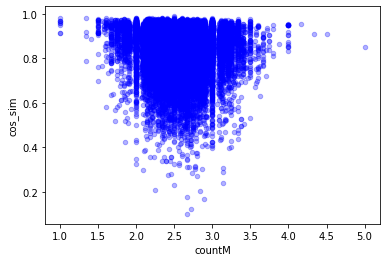

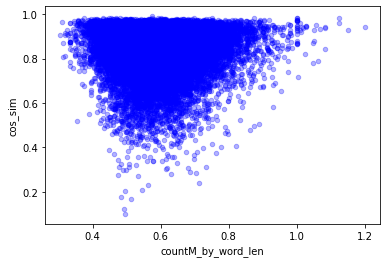

In [51]:
output_dir = "outputs_local_mixed_noise"
dataset_name = "ag_news"
model_name = 'albert-base-v2-ag-news'
seq_max_len=None
# Evaluate tokenizers via WCR
# df = evaluate(dataset_name = dataset_name, model_name=model_name, acc=False)

# Evaluate PLMs via accuracy and cosine similarity
# Evaluating PLMs
df = evaluate(
    output_dir = output_dir,
    dataset_name = dataset_name, 
    model_name=model_name, 
    acc=True, 
    mode="intact", 
    seq_max_len=seq_max_len, 
    countM_by_word_len_min_val = 0.3,
    countM_by_word_len_max_val=0.8,
    no_consistent_pred=False,
    print_acc_sim_by_noise=True)


### Visualize the results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
# box plot

# statistics for different datasets
groups1 = [('SST-2', sst2_wp[metric_name].values), ('Yelp',yelp_wp[metric_name].values), ('AG-News', ag_news_wp[metric_name].values)]
groups2 = [('SST-2', sst2_bpe[metric_name].values), ('Yelp',yelp_bpe[metric_name].values), ('AG-News', ag_news_bpe[metric_name].values)]
groups3 = [('SST-2', sst2_sp[metric_name].values), ('Yelp',yelp_sp[metric_name].values), ('AG-News', ag_news_sp[metric_name].values)]

# statistics for different types of noise
# for name, group in df.groupby('noise_type'):
#     print(name)
#     if name == 'addvowel':
#         rep_bpe = group[['countM', 'countM_by_word_len']]
#     elif name == "keyboard":
#         kb_bpe = group[['countM', 'countM_by_word_len']]
#     elif name == "typoswap":
#         typo_bpe = group[['countM', 'countM_by_word_len']]
#     elif name == "accent":
#         accent_bpe = group[['countM', 'countM_by_word_len']]
#     elif name == "deletevowel":
#         del_wp = group[['countM', 'countM_by_word_len']]
#   typo_bpe accent_bpe 
# metric_name = 'countM_by_word_len'
# groups1 = [
#     ('KB', kb_wp[metric_name].values), 
#     ('Typo',typo_wp[metric_name].values), 
#     ('Accent', np.array([0])),
#     ('Rep',rep_wp[metric_name].values), 
#     ('Del', del_wp[metric_name].values),
#     ]
# groups2 = [
#     ('KB', kb_bpe[metric_name].values), 
#     ('Typo',typo_bpe[metric_name].values), 
#     ('Accent', accent_bpe[metric_name].values),
#     ('Rep',rep_bpe[metric_name].values), 
#     ('Del', del_bpe[metric_name].values),
#     ]
# groups3 = [
#     ('KB', kb_sp[metric_name].values), 
#     ('Typo',typo_sp[metric_name].values), 
#     ('Accent', np.array([0])),
#     ('Rep',rep_sp[metric_name].values), 
#     ('Del', del_sp[metric_name].values),
#     ]


fig = plt.figure( figsize=(6, 4), dpi=1024 )
ax = fig.add_subplot(1,1,1)

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
data1 = []
data2 = []
data3 = []
ticks = []
for name, group in groups1:
    
    if metric_name == 'countM_by_word_len':
        group = group[group<1]
    data1.append(group) 
for name, group in groups2:
    ticks.append(name)
    if metric_name == 'countM_by_word_len':
        group = group[group<1]
    data2.append(group)
for name, group in groups3:
    if metric_name == 'countM_by_word_len':
        group = group[group<1]
    data3.append(group)
    
bpl = ax.boxplot(data1, sym='', positions=np.linspace(0-0.3, len(ticks)-0.3, len(ticks)), widths=0.2)
bp2 = ax.boxplot(data2, sym='', positions=np.linspace(0, len(ticks), len(ticks)), widths=0.2)
bp3 = ax.boxplot(data3, sym='', positions=np.linspace(0+0.3, len(ticks)+0.3, len(ticks)), widths=0.2)
set_box_color(bpl, '#e41a1c') # colors are from http://colorbrewer2.org/
set_box_color(bp2, '#377eb8')
set_box_color(bp3, '#4daf4a')
# draw temporary red and blue lines and use them to create a legend
# plt.plot([], c='#e41a1c', label='Wordpiece')
# plt.plot([], c='#377eb8', label='BPE')
# plt.plot([], c='#4daf4a', label='Sentencepiece')
# plt.legend()
ax.set_xticks(np.linspace(0, len(ticks), len(ticks)), ticks)
ax.set_xlabel('')
ax.set_ylabel('')
if metric_name == 'countM_by_word_len':
    ax.set_ylim(0, 1)
else:
    ax.set_ylim(0, 5.1)

# ax.set_xlim(0, 5)
plt.tight_layout()
plt.show()
# positions=np.array(range(len(bert_sim_by_m_scores)))*2


NameError: name 'sst2_wp' is not defined

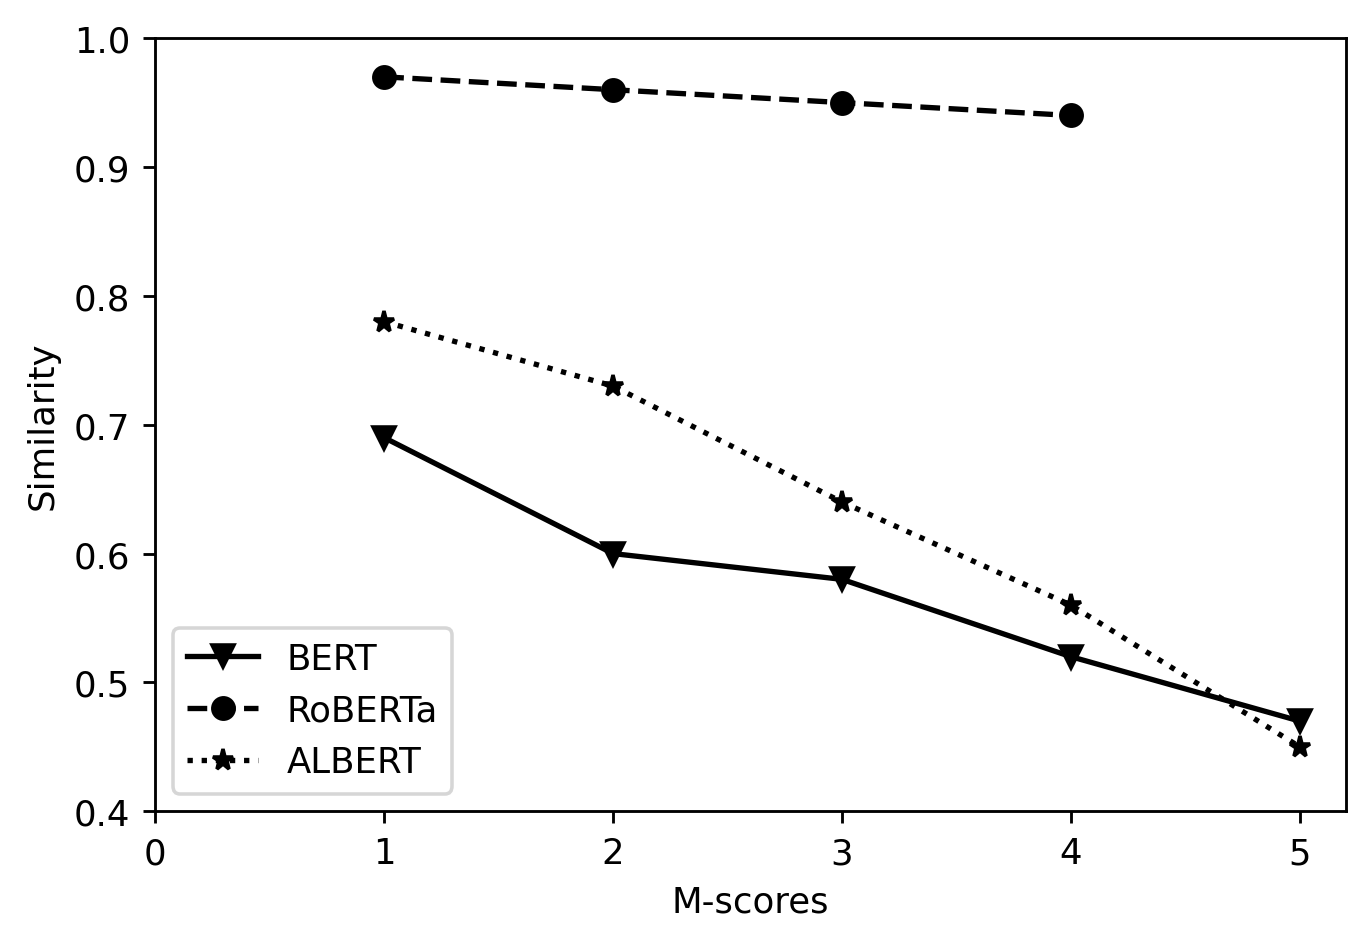

In [103]:
# Correlations between M-score and accuarcy

# sentiment-lexicon-sim
result = {
    'BERT': {1: 0.69, 2: 0.60, 3: 0.58, 4: 0.52, 5: 0.47}, 
    'RoBERTa': {1:0.97,2:0.96,3:0.95,4:0.94},
    'ALBERT': {1:0.78, 2:0.73, 3:0.64, 4:0.56, 5:0.45}
    }

# sst2-sim
# result = {
#     'BERT': {2: 0.52, 3: 0.50, 4: 0.48}, 
#     'RoBERTa': {1:0.56, 2:0.54, 3:0.53},
#     'ALBERT': { 2:0.64, 3:0.57, 4: 0.51}
#     }


# ag-news-sim
# result = {
#     'BERT': {2: 0.87, 3: 0.86, 4: 0.84}, 
#     'RoBERTa': {1:0.52,2:0.56,3:0.54,4:0.58},
#     'ALBERT': { 2:0.75, 3:0.75, 4: 0.74}
#     }

fig = plt.figure( figsize=(6, 4), dpi=256 )
ax = fig.add_subplot(1,1,1)
ax.plot(result['BERT'].keys(), result['BERT'].values(), color='black', linewidth=1.5, linestyle='-', marker='v', label='BERT')
ax.plot(result['RoBERTa'].keys(), result['RoBERTa'].values(), color='black', linewidth=1.5, linestyle='--', marker='o', label='RoBERTa')
ax.plot(result['ALBERT'].keys(), result['ALBERT'].values(), color='black', linewidth=1.5, linestyle=':', marker='*', label='ALBERT')
plt.xticks(np.linspace(0, 5, 6))
plt.yticks(np.linspace(0.4, 1, 7))
ax.set_ylim(0.4,1)
ax.set_xlabel('M-scores')
ax.set_ylabel('Similarity')
plt.legend(loc='best', frameon=True)
plt.show()


In [ ]:
# Correlations between M-score and accuarcy

# sst2-acc
# result = {
#     'BERT': {2: 1-0.68, 3: 1-0.65, 4: 1-0.62}, 
#     'RoBERTa': {1:1-0.76, 2:1-0.74, 3:1-0.71},
#     'ALBERT': { 2:1-0.72, 3:1-0.69, 4: 1-0.66}
#     }

# ag-news-acc
# result = {
#     'BERT': {2: 1-0.91, 3: 1-0.91, 4: 1-0.90}, 
#     'RoBERTa': {1:1-0.66,2:1-0.74,3:1-0.71,4:1-0.74},
#     'ALBERT': { 2:1-0.91, 3:1-0.91, 4: 1-0.90,}
#     }


fig = plt.figure( figsize=(6, 4), dpi=100 )
ax = fig.add_subplot(1,1,1)
ax.plot(result['BERT'].keys(), result['BERT'].values(), color='black', linewidth=1.5, linestyle='-', marker='v', label='BERT')
ax.plot(result['RoBERTa'].keys(), result['RoBERTa'].values(), color='black', linewidth=1.5, linestyle='--', marker='o', label='RoBERTa')
ax.plot(result['ALBERT'].keys(), result['ALBERT'].values(), color='black', linewidth=1.5, linestyle=':', marker='*', label='ALBERT')
plt.xticks(np.linspace(0, 5, 6))
plt.yticks(np.linspace(0, 0.4, 5))
ax.set_ylim(0,0.5)
ax.set_xlabel('WCS-1')
ax.set_ylabel('Misclassification Rate')
plt.legend(loc='best', frameon=True)
plt.show()
# for acc
ax.set_ylim(0,5)
ax.set_ylim(0.6,0.93)



In [53]:
# visualize the noisy text
import pickle
from utils import visualize_text_diff
dataset_name = 'ag_news'
with open(f"outputs_local_mixed_noise/{dataset_name}_noisy.pickle", 'rb') as file:
    samples = dict(pickle.load(file))
visualize_text_diff(samples[0]['x'], samples[0]['x_noise5'], color_method='html')